# Exploratory Data Analysis 
***
This notebook is a guide to understanding the preprocessing feature engineering steps taken to prepare the data for model training.

Before performing data analysis, the raw data is processed through a pipeline based on domain knowledge to make it suitable for analysis. The parsed CSV files are filtered, cleaned and converted to the 'parquet' file format which is better suited for large datasets and complex queries.

## Import necessary libraries 

In [12]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
import time

## Define path to data directory

In [13]:
data_dir = '../data/preprocessed_data/'

## Data Selection

As the number of '*normal*' instances far outnumber the '*abnormal*' or '*anomalous*' instances, we will ignore all files which contain no anomalies. Another reason to ignore these files is the high correlation between the features and the target. However, with sufficient compute power and time to train, this data can be used to better train the model to '*normal*' instances.  

In [14]:
st = time.time()
data = []
for f in os.listdir(data_dir):
    df = dd.read_parquet(os.path.join(data_dir, f))
    if len(df['label'].unique()) == 1: 
        continue
    else:
        data.append(df)

df = dd.concat(data)
print(df.compute().shape)
print(f"Time taken to read files:", time.time() - st,"seconds")

(2280812, 101)
Time taken to read files: 61.83689022064209 seconds


In [15]:
st = time.time()
data = []
for f in os.listdir(data_dir):
    df = pd.read_parquet(os.path.join(data_dir, f))
    if len(df['label'].unique()) == 1:
        continue
    else:
        data.append(df)

df = pd.concat(data)
print(df.shape)
print(f"Time taken to read files:", time.time() - st,"seconds")
df.reset_index(drop=True, inplace=True)

(2280812, 101)
Time taken to read files: 16.619616508483887 seconds


Even after data selection, we have over 2 million instances with mixed labels. We used the Dask library to process the raw data in order to utilize our machine's parallel processing capabilites. As seen above on calling `df.shape`, Dask does not actually load the data into memory, but instead returns a **'Delayed'** object. Dask dataframes are *lazy* by nature, until the `compute()` method is called. However, the data has already been converted to "parquet" format, which is 4-10x faster to read and write when compared to formats like CSV. As can be seen above, Pandas can read this cleaner data faster than Dask.

## Class Imbalance

Even after selecting only the required data files, there is a big imbalance in the target classes. Class imbalance can be a tricky issue, but there are several strategies that can address it. Some of them are:

1. Resampling: Oversampling or undersampling the minority or majority class can balance the class distribution.

2. Some algorithms allow us to assign different weights to classes. Since we are using state-of-the-art models, we aim not to modify the training processes of these models, but instead making the data suitable for processing.

3. Appropriate evaluation metrics can be used when dealing with imbalanced datasets.

In [16]:
df['label'].value_counts()

label
0.0    2025739
1.0     255073
Name: count, dtype: int64

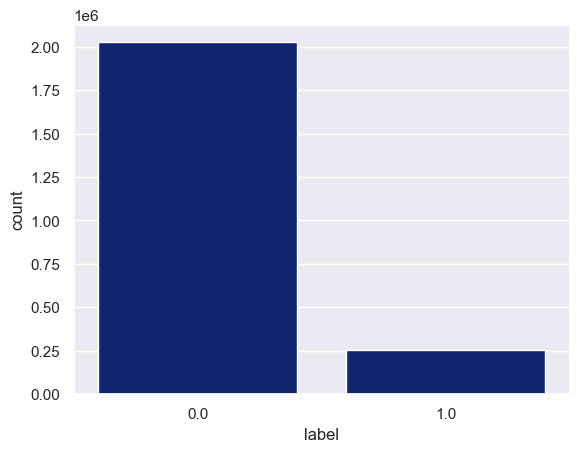

In [17]:
sns.set(style='darkgrid', palette='dark')
sns.countplot(x = df['label'])
plt.savefig('./figures/class_distribution')
plt.show()

The anomalous instances are severely outnumbered even after selectively choosing our data. However, the aim is to train a model that can successfully detect anomalies, which by nature are rarer than *'normal'* instances. Hence we will keep our distribution as is, where the *'outliers'* form about 10% of our entire dataset. 

## Feature Selection

When creating a custom dataset, feature selection is often done based on domain knowledge of the task being performed. It is done for several reason, including but not limited to:

1. Preventing overfitting: Including too many features, especially when the number of features is comparable to the number of observations, can lead to overfitting.

2. Computational efficiency: Including irrelevant or redundant features increases the computational complexity of the model. Feature selection helps in reducing the dimensionality of the dataset, making the training process faster and more efficient.

3. Interpretability: A model with fewer features is often easier to interpret and understand. This is important in many real-world applications where stakeholders need to comprehend and trust the model's decisions.

In order to select relevant columns for training our model, we must understand the nature of exploits that can be used within the demo. There are 3 main types of exploits:

* Vision assistance: Including cheats like wallhacks.
* Aim assistance: Aimbots, spinbots fall within this category.
* Server manipulation: DDOS attacks, forcefully inducing rubberbanding etc.

While vision and aim assistance can also be caught by vision-based deep learning models, we aim to also catch malicious acts of server manipulation.


In [18]:
sorted(df.columns)

['attackerBlinded',
 'attackerSteamID',
 'attackerStrafe',
 'attackerViewX',
 'attackerViewY',
 'attackerX',
 'attackerY',
 'attackerZ',
 'clockTime',
 'ctAlivePlayers',
 'ctScore',
 'ctTeam',
 'destroyClockTime',
 'destroySeconds',
 'destroyTick',
 'distance',
 'endCTScore',
 'endOfficialTick',
 'endTScore',
 'endTick',
 'entityId',
 'eyeX',
 'eyeY',
 'eyeZ',
 'fireGrenades',
 'flashGrenades',
 'flashThrowerName',
 'flashThrowerSteamID',
 'grenadeType',
 'grenadeX',
 'grenadeY',
 'grenadeZ',
 'hasBomb',
 'heGrenades',
 'hitGroup',
 'isAirborne',
 'isAlive',
 'isBlinded',
 'isBot',
 'isDefusing',
 'isDucking',
 'isDuckingInProgress',
 'isFirstKill',
 'isFriendlyFire',
 'isHeadshot',
 'isPlanting',
 'isReloading',
 'isScoped',
 'isStanding',
 'isSuicide',
 'isTeamkill',
 'isUnDuckingInProgress',
 'isUnknown',
 'isWalking',
 'isWallbang',
 'label',
 'lastPlaceName',
 'mapName',
 'noScope',
 'penetratedObjects',
 'ping',
 'playerName',
 'playerStrafe',
 'playerViewX',
 'playerViewY',
 'pl

Based on the above description, the following columns can be removed as the exploits mentioned above would have little to no effect on them.

In [19]:
drop_cols = ['destroyTick', 'destroySeconds', 'throwSeconds','throwerX', 'throwerY', 'throwerZ', 'grenadeX', 'grenadeY', 'grenadeZ', 'flashThrowerSteamID', 'flashGrenades','smokeGrenades', 'heGrenades', 'fireGrenades', 'throwClockTime', 'destroyClockTime','grenadeType', 'flashThrowerName' ]
df.drop(drop_cols, axis=1, inplace=True)

## Correlated Features

Removing highly correlated features from a dataset before training a machine learning model is also a part of feature selection, often done to improve the model's performance and interpretability.

1. Redundancy: Highly correlated features provide essentially the same information to the model, making it redundant.

2. Model performance: Correlated features can lead to multicollinearity, which can destabilize linear models (e.g., linear regression) and make it challenging for them to estimate the individual contributions of each feature accurately.

3. Efficiency: Training a model with fewer features, especially when working with large datasets, can significantly reduce the computational resources and time required for training.

4. Improved generalization: Removing correlated features can help the model generalize better to unseen data by reducing the noise introduced by the correlated features.

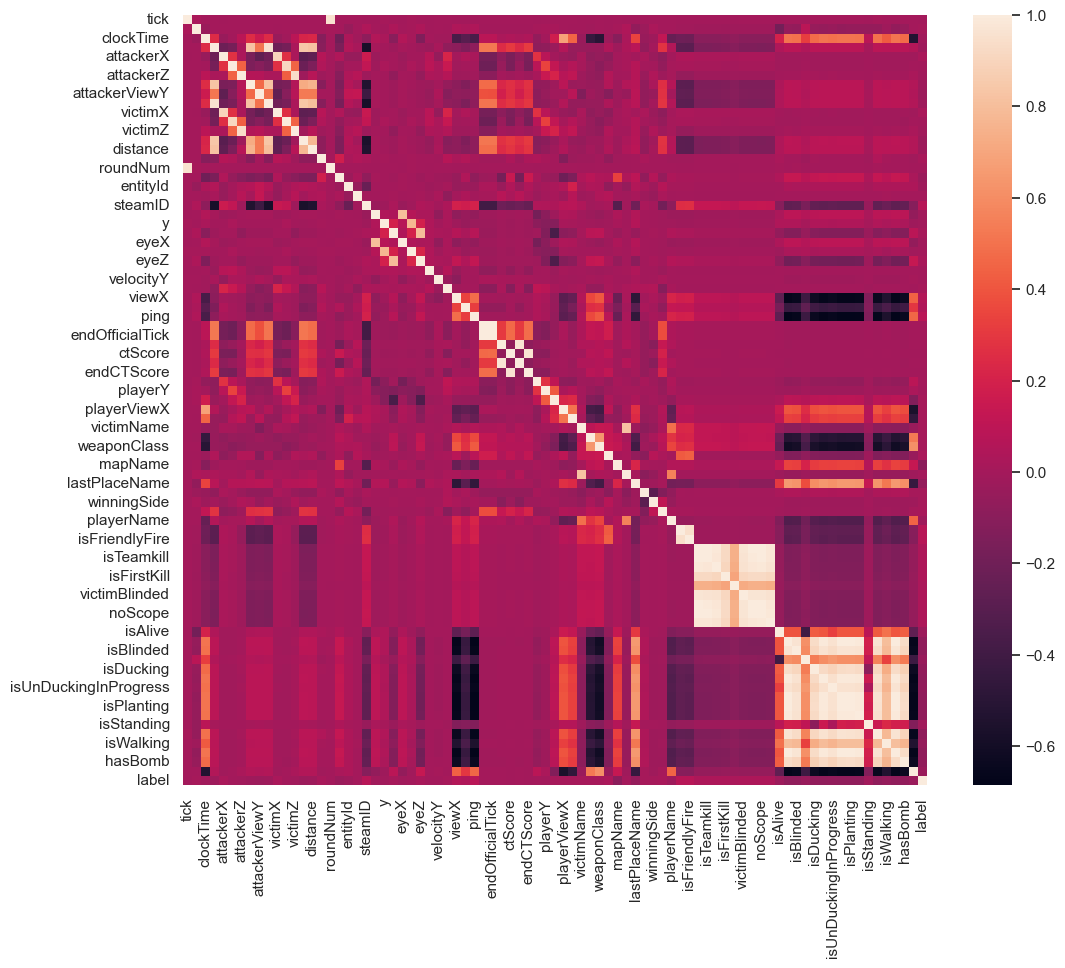

In [20]:
corr = df.corr(method='kendall')
plt.figure(figsize=(12,10))
sns.heatmap(corr)
plt.savefig('./figures/initial_correlation')
plt.show()

In [21]:
corr_col = set()
for i in range(len(df.columns)):
    for j in range(i):
        if corr.iloc[i, j] > 0.8:
            col = corr.columns[i]
            corr_col.add(col)

df = df.drop(corr_col, axis=1)

In [22]:
sorted(df.columns)

['attackerSteamID',
 'attackerStrafe',
 'attackerViewY',
 'attackerX',
 'attackerY',
 'attackerZ',
 'clockTime',
 'ctAlivePlayers',
 'ctScore',
 'ctTeam',
 'endTick',
 'entityId',
 'eyeX',
 'eyeY',
 'eyeZ',
 'hitGroup',
 'isAirborne',
 'isAlive',
 'isBot',
 'isHeadshot',
 'isStanding',
 'isSuicide',
 'label',
 'lastPlaceName',
 'mapName',
 'penetratedObjects',
 'ping',
 'playerName',
 'playerStrafe',
 'playerViewX',
 'playerViewY',
 'playerX',
 'playerY',
 'playerZ',
 'roundEndReason',
 'seconds',
 'steamID',
 'tScore',
 'tick',
 'velocityX',
 'velocityY',
 'velocityZ',
 'victimName',
 'viewX',
 'viewY',
 'weapon',
 'weaponClass',
 'winningSide',
 'x',
 'y',
 'z',
 'zoomLevel']

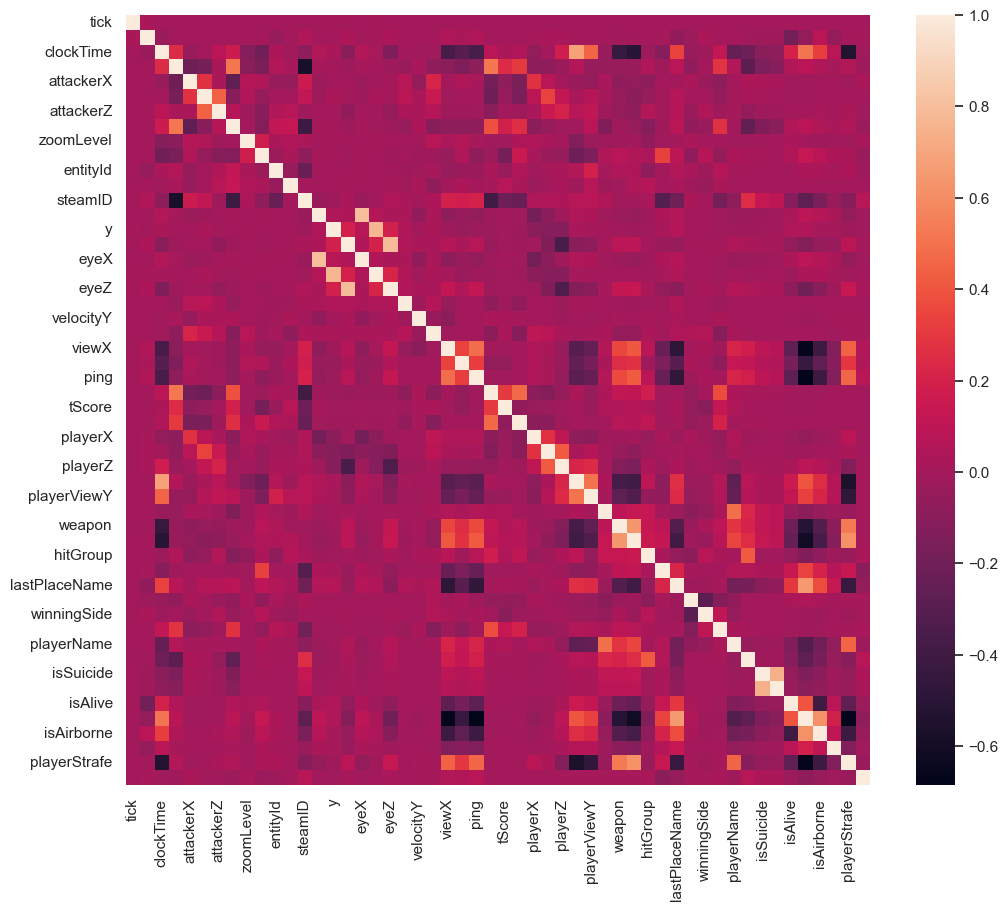

In [23]:
corr_ = df.corr(method='kendall')
plt.figure(figsize=(12,10))
sns.heatmap(corr_)
plt.savefig('./figures/fixed_correlation')
plt.show()

In [24]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2280812 entries, 0 to 2280811
Data columns (total 52 columns):
 #   Column             Dtype  
---  ------             -----  
 0   tick               float64
 1   seconds            float64
 2   clockTime          float64
 3   attackerSteamID    float64
 4   attackerX          float64
 5   attackerY          float64
 6   attackerZ          float64
 7   attackerViewY      float64
 8   zoomLevel          float64
 9   ctAlivePlayers     float64
 10  entityId           float64
 11  penetratedObjects  float64
 12  steamID            float64
 13  x                  float64
 14  y                  float64
 15  z                  float64
 16  eyeX               float64
 17  eyeY               float64
 18  eyeZ               float64
 19  velocityX          float64
 20  velocityY          float64
 21  velocityZ          float64
 22  viewX              float64
 23  viewY              float64
 24  ping               float64
 25  endTick           

## Feature Transformation

We perform feature transformation to further reduce the number as well as enhance the interpretability of our features.

1. Feature Scaling for Distance-Based Algorithms: Algorithms that rely on distances between data points, such as k-nearest neighbors or support vector machines, can benefit from feature scaling to ensure that features with larger scales do not dominate the distance calculations.

2. Improving Interpretability: Transformation can sometimes make the relationships between variables more interpretable. For example, taking the square root of a variable might make the relationship more linear and easier to understand.

3. Improving Convergence and Training Speed: Proper feature transformation can sometimes lead to faster convergence during the training of machine learning models. It can also contribute to more stable and efficient training processes.


In our dataset we have multiple columns that represent the coordinates in a Cartesian plane for events associated with multiple attributes.

In [25]:
coord_cols = []
for col in df.columns:
    if col.endswith(('x', 'y', 'z', 'X', 'Y', 'Z')):
        coord_cols.append(col)
coord_cols

['attackerX',
 'attackerY',
 'attackerZ',
 'attackerViewY',
 'x',
 'y',
 'z',
 'eyeX',
 'eyeY',
 'eyeZ',
 'velocityX',
 'velocityY',
 'velocityZ',
 'viewX',
 'viewY',
 'playerX',
 'playerY',
 'playerZ',
 'playerViewX',
 'playerViewY']

In [26]:
identifiers = []
for col in coord_cols:
    identifier = col[:-1]
    if len(identifier) == 0:
        continue
    else:
        identifiers.append(identifier)
identifiers = set(identifiers)

changes_dict = {}

for identifier in identifiers:
    identifier_columns = [column for column in coord_cols if column.startswith(identifier) and column[len(identifier)] in ['X', 'Y', 'Z']]
    changes_dict[identifier] = identifier_columns

for new_col, old_cols in changes_dict.items():
    df[new_col] = 0
    for i in range(len(old_cols)):
        df[new_col] += df[old_cols[i]] * 10**(-(i+1))
    
    df.drop(columns=old_cols, inplace=True)

df.shape

(2280812, 42)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2280812 entries, 0 to 2280811
Data columns (total 42 columns):
 #   Column             Dtype  
---  ------             -----  
 0   tick               float64
 1   seconds            float64
 2   clockTime          float64
 3   attackerSteamID    float64
 4   zoomLevel          float64
 5   ctAlivePlayers     float64
 6   entityId           float64
 7   penetratedObjects  float64
 8   steamID            float64
 9   x                  float64
 10  y                  float64
 11  z                  float64
 12  ping               float64
 13  endTick            float64
 14  tScore             float64
 15  ctScore            float64
 16  victimName         float64
 17  weapon             float64
 18  weaponClass        float64
 19  hitGroup           float64
 20  mapName            float64
 21  lastPlaceName      float64
 22  ctTeam             float64
 23  winningSide        float64
 24  roundEndReason     float64
 25  playerName        

In [37]:
if 'x' in df.columns and 'y' in df.columns and 'z' in df.columns:
    df['pos'] = df['x'] * 10**(-1) + df['y']* 10**(-2) + df['z'] * 10**(-3)
    df.drop(['x', 'y', 'z'], axis=1, inplace=True)

Lastly, we move the target column 'label' to the last for better understandability.

In [38]:
label_col = df['label']
df.drop(['label'], axis=1, inplace=True)
df['label'] = label_col
df

,tick,seconds,clockTime,attackerSteamID,zoomLevel,ctAlivePlayers,entityId,penetratedObjects,steamID,ping,...,playerStrafe,player,playerView,attacker,velocity,attackerView,eye,view,pos,label
0,-1.967474,-1.309369,-0.644363,-0.269393,-0.198324,-0.232165,-0.148963,-0.019054,-2.304538,-0.915681,...,1.0,0.048376,-0.051950,0.023428,0.002696,-0.015455,0.093505,-0.096950,0.094630,0.0
1,-1.663168,-1.305020,2.222920,-0.269393,-0.198324,-0.232165,-0.148963,-0.019054,0.433926,-0.915681,...,0.0,-0.175400,0.139020,0.023428,0.002696,-0.015455,0.093505,-0.096950,0.094630,0.0
2,-1.663008,-1.309369,-0.644363,-0.269393,-0.198324,-0.232165,1.960682,-0.019054,-2.304538,-0.915681,...,1.0,0.048376,-0.051950,0.023428,0.002696,-0.015455,0.093505,-0.096950,0.094630,0.0
3,-1.661568,-1.254279,-0.644363,-0.269393,-0.198324,-0.232165,-0.148963,-0.019054,0.433926,1.088526,...,1.0,0.048376,-0.051950,0.023428,0.075670,-0.015455,0.018176,0.143932,0.020000,0.0
4,-1.661568,-1.254279,-0.644363,-0.269393,-0.198324,-0.232165,-0.148963,-0.019054,0.433926,0.286843,...,1.0,0.048376,-0.051950,0.023428,-0.091148,-0.015455,-0.021979,0.120691,-0.019721,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280807,1.728833,-1.223700,-0.630870,-0.269152,-0.145738,-0.225373,-0.128853,-0.014201,0.424978,0.424321,...,1.0,0.047547,-0.049614,0.023255,-0.002543,-0.013773,0.078616,0.117804,0.078134,0.0
2280808,1.728906,-1.221425,0.333573,-0.269152,-0.145738,-0.225373,-0.128853,-0.014201,0.424978,-0.804775,...,0.0,-0.023862,0.071850,0.023255,-0.002543,-0.013773,0.094382,-0.096694,0.093784,0.0
2280809,1.729100,-1.215358,0.333573,3.715371,-0.145738,-0.225373,-0.128853,-0.014201,-2.353063,-0.804775,...,1.0,0.047547,-0.049614,-0.106050,-0.002543,-0.012690,0.094382,-0.096694,0.093784,0.0
2280810,1.729100,-1.215358,0.333573,3.715371,-0.145738,-0.225373,-0.128853,-0.014201,-2.353063,-0.804775,...,1.0,0.047547,-0.049614,-0.106050,-0.002543,-0.012690,0.094382,-0.096694,0.093784,0.0


Tracing our journey from the parsed CSV files extracted from each demo file, we have reduced the number of features from 160 to 39 with 1 target variable. This not only greatly decreases the size of our dataset and the time it will take for our models to be trained, but also massively enhances understandability.

## Save the optimized dataset

Finally, we will check if any columns can be converted from *'float64'* to *'int64'* data type, perform the conversion, and save the file.

In [39]:
for column in df.columns:
    if df[column].apply(lambda x: x.is_integer() if not pd.isna(x) else True).all():
        df[column] = df[column].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2280812 entries, 0 to 2280811
Data columns (total 40 columns):
 #   Column             Dtype  
---  ------             -----  
 0   tick               float64
 1   seconds            float64
 2   clockTime          float64
 3   attackerSteamID    float64
 4   zoomLevel          float64
 5   ctAlivePlayers     float64
 6   entityId           float64
 7   penetratedObjects  float64
 8   steamID            float64
 9   ping               float64
 10  endTick            float64
 11  tScore             float64
 12  ctScore            float64
 13  victimName         int64  
 14  weapon             int64  
 15  weaponClass        int64  
 16  hitGroup           int64  
 17  mapName            int64  
 18  lastPlaceName      int64  
 19  ctTeam             int64  
 20  winningSide        int64  
 21  roundEndReason     int64  
 22  playerName         int64  
 23  attackerStrafe     int64  
 24  isSuicide          int64  
 25  isHeadshot        

In [40]:
save_dir = "../data"
df.to_parquet(os.path.join(save_dir, 'anomalyDataset.parquet'), index=False)